In [2]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rn

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# matplotlib preferences
mpl.rcdefaults()  # reset
plt.rc('axes', titlesize=20, labelsize=15)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('lines', linewidth=1, markersize=5)
plt.rc('figure', figsize=(5, 5))
# print(plt.rcParams) # all parameters

## Coursework 3A - Steady-state advection-diffusion with the FEM

Here I chose to use the lecture 11 method as it seemed more hands on. To begin with the derivation for our Finite Element (FE) scheme with the AD equation needs to be done.

<img src="figs/steady_math.jpg" alt="da math">

Now that we have the equation we are solving for the solver can be setup.

In [5]:
class Advec_Diff():
    """
    This object stores the state of the system and all the parameters that define it.
    The methods are for finding the base functions and matrices as well as time step
    the system and analysing the current state.
    """
    def __init__(self, nodes, u, k, bounds):
        """
        Initialse the system. Nodes includes the limits with
        dirichlet boundary conditions given in bounds.
        """
        # store the consants given
        self.u = u
        self.k = k
        self.Ce_L, self.Ce_R = bounds
        self.L =  (nodes[-1] - nodes[0])
        self.Pe = u * self.L / self.k
        
        # create the grid
        self.x = np.array(nodes)
        self.dx = np.diff(self.x)
        self.N = self.x.size
        self.lims = [self.x[0], self.x[-1]]
        
        # create the bases functions
        self.bases = [self.base_func(i) for i in range(self.N)]
        self.base_derivs = [self.base_func_deriv(i) for i in range(self.N)]
        
        # find the matrices
        self.K_ = np.array([self.mat_row(i, 'K') for i in range(self.N)])[1:-1, 1:-1]
        self.R_ = np.array([self.mat_row(i, 'R') for i in range(self.N)])[1:-1, 1:-1]
        return
            
    def base_func(self, i):
        "find the i th base function (hat function)"
        assert 0 <= i < self.N, 'i out of range' 
        if i == 0:
            return lambda x: np.select([np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(self.x[i+1]-x)/self.dx[i]], 0.0)
        elif i == self.N-1:
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i])],
                                        [(x-self.x[i-1])/self.dx[i-1]], 0.0)
        else:
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i]),
                                        np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(x-self.x[i-1])/self.dx[i-1],
                                        (self.x[i+1]-x)/self.dx[i]], 0.0)
    
    def base_func_deriv(self, i):
        "find the i th base function derivative"
        assert 0 <= i < self.N, 'i out of range' 
        if i == 0:
            return lambda x: np.select([np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(-1)/self.dx[i]], 0.0)
        elif i == self.N-1:
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i])],
                                        [(1)/self.dx[i-1]], 0.0)
        else:
            return lambda x: np.select([np.logical_and(self.x[i-1] <= x, x <= self.x[i]),
                                        np.logical_and(self.x[i] <= x, x <= self.x[i+1])],
                                        [(1)/self.dx[i-1], (-1)/self.dx[i]], 0.0)
    
    def mat_row(self, i, s):
        "Analytically find the i th row of either M, K or R matrices"
        assert 0 <= i < self.N, 'i out of range'
        row = np.zeros(self.N)
        
        if s == 'K':
            if i == 0:
                row[i] = 1/self.dx[i]
                row[i+1] = -1/self.dx[i]
            elif i == self.N-1:
                row[i-1] = -1/self.dx[i-1]
                row[i] = 1/self.dx[i-1]
            else:
                row[i-1] = -1/self.dx[i-1]
                row[i] = 1/self.dx[i-1] + 1/self.dx[i]
                row[i+1] = -1/self.dx[i]
            return row

        elif s == 'R':
            if i == 0:
                row[i+1] = 1/2
                row[i] = -1/2
            elif i == self.N-1:
                row[i] = 1/2
                row[i-1] = -1/2
            else:
                row[i-1] = -1/2
                row[i+1] = 1/2
            return row
    
    def exact_slution(self, x):
        "The exact solution for a guassian centered x0 at t=0 with infinite height"
        return self.Ce_R * (np.exp(self.Pe * x / self.L) - 1) / (np.exp(self.Pe) - 1)

    def steady_state(self):
        "solve the system to find the steady state"
        # setup the equation
        RHS = np.zeros(self.N - 2)
        RHS[0] = -self.Ce_L * (self.u / (self.k * 2) + 1/self.dx[0])
        RHS[-1] = self.Ce_R * (self.u / (self.k * 2) - 1/self.dx[-1])
        mat = -self.K_ - self.u * self.R_ / self.k
        
        # solve and add in the boundaries
        C = lin.solve(mat, RHS)
        self.C = np.pad(C, 1, 'constant', constant_values=0)
        self.C[[0, -1]] = self.Ce_L, self.Ce_R
        
    def plot(self, ax=None, sol=True, exact=True, elements=False):
        """
        Plot the current state of the system
        
        Parameters
        ----------
        ax : matplotlib axes, optional
            The axis to plot on, creates an axis if None given
        numeric : bool, optional
            Plot the numeric result
        analytical : bool, optional
            Plot the analytical result
        elemtents : bool, optional
            Plot the result over elements
        
        Returns
        -------
        ax : matplotlib axes
            axis results were plotted on
        """
        if ax == None:
            fig, ax = plt.subplots()
            ax.set(title='System Solution', xlabel='x', ylabel='C(x)')
        if sol:
            ax.plot(self.x, self.C, 'bo', label='numeric')
        if exact:
            x_fine = np.linspace(*self.lims, 1000)
            ax.plot(x_fine, self.exact_slution(x_fine), 'r-', label='analytic')
        if elements:
            x_fine = np.linspace(*self.lims, 1000)
            ax.plot(x_fine, self.continuous_solution(x_fine), 'b--', label='elemtents')
        ax.legend()
        return ax
    
    def error_nodes(self):
        "find the RMS error at the nodes"
        exact = self.exact_slution(self.x)
        diff_sq = (self.C - exact)**2
        return np.sqrt(sum(diff_sq / self.N))
    
    def continuous_solution(self, x):
        "Sum over the basis functions to find the solution for arbitary x in the solution range."
        assert np.any(np.logical_and(self.lims[0] <= x, x <= self.lims[1])), 'x given is out of range'
        return sum(self.C[n]*self.bases[n](x) for n in range(self.N))
    
    def error_elements(self, n=1000):
        "find the RMS error across the centeral th element using n samples"
        i = int(self.N/2)
        x_samp = np.linspace(self.x[i], self.x[i+1], n)
        exact =  self.exact_slution(x_samp)
        numeric = self.continuous_solution(x_samp)
        diff_sq = (numeric - exact)**2
        return np.sqrt(sum(diff_sq / n))
    
#     def mat_row(self, i, s):
#         "calculate a row of matrix with string s"
#         assert 0 <= i < self.N, 'i out of range'
#         row = np.zeros(self.N)
#         n_samp = 10000
        
#         # select the functions based on the matrix
#         if s == 'M':
#             f = self.bases
#             g = self.bases
#         elif s == 'K':
#             f = self.base_derivs
#             g = self.base_derivs
#         elif s == 'R':
#             f = self.bases
#             g = self.base_derivs
#         else:
#             raise ValueError('matrix string unknown')

#         # left entry
#         if i != 0:
#             Integrand = lambda x: f[i](x) * g[i-1](x)
#             row[i-1] = self.simpsons_rule(Integrand, n_samp, self.x[i-1], self.x[i])

#         # right entry
#         if i != self.N-1:
#             Integrand = lambda x: f[i](x) * g[i+1](x)
#             row[i+1] = self.simpsons_rule(Integrand, n_samp, self.x[i], self.x[i+1])
        
#         # diagonal entry
#         Integrand = lambda x: f[i](x) * g[i](x)
#         if i == 0:
#             row[i] = self.simpsons_rule(Integrand, n_samp, self.x[i], self.x[i+1])
#         elif i == self.N-1:
#             row[i] = self.simpsons_rule(Integrand, n_samp, self.x[i-1], self.x[i])
#         else:
#             row[i] += self.simpsons_rule(Integrand, n_samp, self.x[i], self.x[i+1])
#             row[i] += self.simpsons_rule(Integrand, n_samp, self.x[i-1], self.x[i])

#         return row
    
#     def K_row(self, i):
#         "find a row of K"

#     def simpsons_rule(self, f, n, xmin, xmax):
#         assert n%2 == 0, 'number of intervals must be even'
#         xs = np.linspace(xmin, xmax, n+1)
#         dx = xs[1] - xs[0]
#         evals = f(xs)
#         return (evals[0] + evals[-1] + (4 * evals[1:-1:2]).sum() + (2 * evals[2:-1:2]).sum()) * dx / 3
        

A few things to note about this implementation:

1. Matrices K, R are found analytically and hard coded. Hashed are some methods that are more numerical but there is an issue with exactly computing the integrals of discontinuous derivatives so it has been left out

2. The bases functions and there derivatives are stored so that they can be reused to find the solution over the elements as well as at the nodes.

3. Both the error at the nodes and the error across an element are calculated using

Lets run this solver and compare it to the known solution

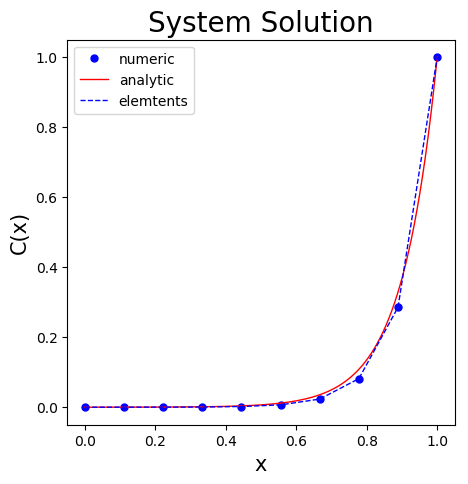

In [6]:
# setup and solve the system with FE
system = Advec_Diff(nodes=np.linspace(0, 1, 10), u=0.05, k=0.005, bounds=[0, 1])
system.steady_state()
system.plot(elements=True)
plt.show()

THe true solution has positive curvature throughout, so a linear interpolation would be a constant overestimation (except at the nodes). Hence our better solution with the finite element method would be expected to be under the true solution at every node, which is observed above.

For comparison I will reuse my code from ACSE3-2 where we used finite difference (FD) on the same problem. Note this solver uses ghost nodes ON THE BOUNDARIES for Dirichlet boundary conditions, hence treats the boundaries in the same way as the FE solver above. 

In [7]:
# finite difference solver code form ACSE3 project 2
def ghost_uni_dis(Nx, lims, kappa, U):
    "Find the centeral difference matrix for uniform meshgrid"
    
    # find x array
    x = np.linspace(lims[0], lims[1], Nx)
    dx = x[1] - x[0]

    # set up matrix
    A = np.zeros([Nx, Nx])
    tmp1 = -2 * dx * kappa
    tmp2 = U / 2
    
    # find matrix entries
    for i in range(1, Nx-1):
        sigma = 2 * dx**3
        A[i, i-1] = -tmp1 / sigma - tmp2 * (-1/dx)
        A[i, i] = 2 * tmp1 / sigma - tmp2 * ((1/dx) - (1/dx))
        A[i, i+1] = -tmp1 / sigma - tmp2 * (1/dx)

    # add in the ghost nodes
    A[0, 0] = 1.
    A[-1, -1] = 1.

    return A

def stationary_uniform(Nx, kappa, U, L, lims):
    "solve for stantionary solution with uniform spacal grid using numpy linalg solve"
    print('Solving steady state with uniform dx = ', 1/(Nx-1))
    # set up the RHS with boundary conditions
    RHS = np.zeros(Nx)
    RHS[0] = 0
    RHS[-1] = 1
    
    # find the matrix
    A = ghost_uni_dis(Nx, lims, kappa, U)
    solution = np.linalg.solve(A, RHS)
    
    # find the error
    x = np.linspace(*lims, Nx)
    Pe = U * L / kappa
    analytical =  (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)
    error = np.sqrt(((analytical - solution)**2).sum() / Nx)
    
    return solution, error

Solving steady state with uniform dx =  0.1111111111111111


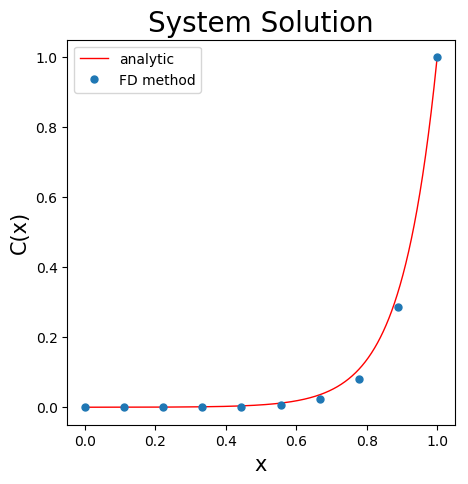

In [9]:
solution, err = stationary_uniform(Nx=10, kappa=0.005, U=0.05, L=1, lims=[0, 1])
system.plot(sol=False)  # plot analytical solution from before
x_vals = np.linspace(0,1,10)
plt.plot(x_vals, solution, 'o', label='FD method')
# system.plot()
plt.legend()
plt.show()

These solvers appear very similar, to fully compare them a convergence plot is needed.

In [18]:
# range of dx values 
Ns = np.array([2**n for n in range(3, 12)])
dxs = 1/Ns
xs = [np.linspace(0, 1, n) for n in Ns]

# setup error arrays and paramters
error_nodes = []
error_element = []
error_FD = []
u, k, bounds =  0.05, 0.005, [0, 1]

# solve for each
for i, x_ in enumerate(xs):
    print('solving dx = ', dxs[i])
    
    # Finite element
    system = Advec_Diff(x_, u, k, bounds)
    system.steady_state()
    error_nodes += [system.error_nodes()]
    error_element += [system.error_elements()]
    
    # finite difference
    solution, err = stationary_uniform(Nx=len(x_), kappa=0.005, U=0.05, L=1, lims=[0, 1])
    error_FD += [err]

solving dx =  0.125
Solving steady state with uniform dx =  0.14285714285714285
solving dx =  0.0625
Solving steady state with uniform dx =  0.06666666666666667
solving dx =  0.03125
Solving steady state with uniform dx =  0.03225806451612903
solving dx =  0.015625
Solving steady state with uniform dx =  0.015873015873015872
solving dx =  0.0078125
Solving steady state with uniform dx =  0.007874015748031496
solving dx =  0.00390625
Solving steady state with uniform dx =  0.00392156862745098
solving dx =  0.001953125
Solving steady state with uniform dx =  0.0019569471624266144
solving dx =  0.0009765625
Solving steady state with uniform dx =  0.0009775171065493646
solving dx =  0.00048828125
Solving steady state with uniform dx =  0.0004885197850512946


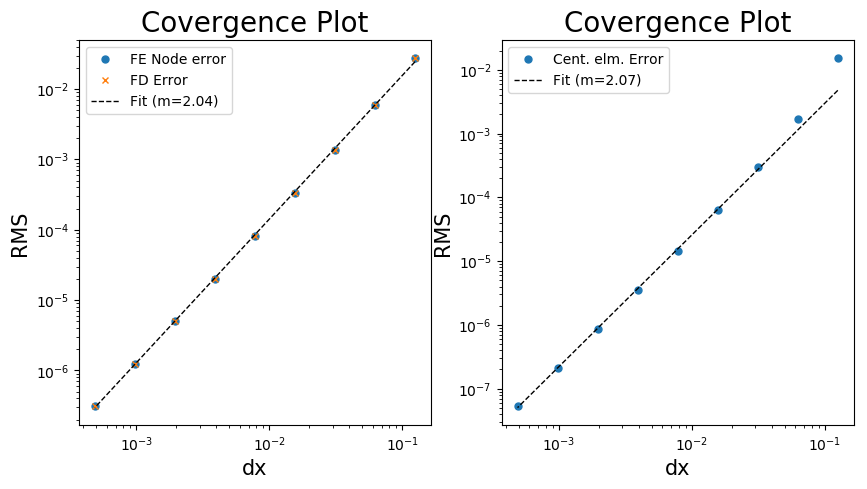

In [29]:
# plot results
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].loglog(dxs, np.array(error_nodes), 'o', label='FE Node error')
axs[0].loglog(dxs, np.array(error_FD), 'x', label='FD Error')
axs[1].loglog(dxs, np.array(error_element), 'o', label='Cent. elm. Error')
axs[0].set(title='Covergence Plot', xlabel='dx', ylabel='RMS')
axs[1].set(title='Covergence Plot', xlabel='dx', ylabel='RMS')

# plot fit lines
log_dxs = np.log10(dxs)
N_params = np.polyfit(log_dxs[:], np.log10(error_nodes[:]), 1)
E_params = np.polyfit(log_dxs[2:], np.log10(error_element[2:]), 1)
axs[0].loglog(dxs, 10**N_params[1] * dxs**N_params[0], 'k--', label='Fit (m=%.2f)'%N_params[0])
axs[1].loglog(dxs, 10**E_params[1] * dxs**E_params[0], 'k--', label='Fit (m=%.2f)'%E_params[0])
axs[0].legend()
axs[1].legend()
plt.show()

First thing one notices is that the error for finite difference and finite element at the nodes are identical. Assuming this is not some mistake in the way I have plotted my results this suggests that in the case of a one dimensional uniform grid with p/w linear base functions FE reduces to the FD method (for ghost nodes on the boundary). The fact that my implementations for FE and FD are quite different is strong evidence that this is the case and seeing as both methods use the same method for discretisation in space (central) it seems plausible that this is the case.

The second thing we see is that the convergence at the nodes and elements for FE are both $\mathcal{O}(dx) \sim 2$; where as from lecture 11 we would expect the error at the nodes to be $4th$ order. The fact that the error across the elements is the same as those at the nodes (and themselves are as expect) suggests that for this case the nodes don't hold the property of greater convergence order for this problem. The lecture 11 example is for just diffusion, not advection diffusion which could explain this. Another possibility is a bug in the error calculations or code implementation, but again the exact match between FD and FE suggest both are implemented properly (or the bug affects the way we compare the codes).

Both error orders being slightly above 2 is slightly odd as one expect the predicted convergence orders to be the optimal values, with higher order terms causing slightly worse performance. One possibility is the impact the ghost nodes being included in the error metric could improve the observed performance. If I had more time I would correct the error calculation to not include boundary nodes.
